# **Portfolio & Long-Lived Series (PS3→PS4→PS5)**

## **Step 1 - Business Understanding**

### **Problem**
We want to understand how sequel performance changes across console generations and which publishers are the most stable.

### **Main Questions**
- **Q1:** Do sequels grow or decline when moving PS3→PS4 and PS4→PS5?
- **Q2:** Which publishers show stable results over multiple years?

### **Objectives**
- **O1:** Build a Series Performance Index normalized inside each *platform × year*.
- **O2:** Measure sequel delta (Part N+1 − Part N) and generation jump effect.
- **O3:** Rank publishers by stability (high median, low variance).

### **Scope**
**In:** PS3/PS4/PS5 games, series grouping, release year, publisher, sales/revenue.  
**Out:** unit forecasts, causal explanations, non-PlayStation platforms.

### **Data**
- Game title  
- Series / Franchise  
- Part number  
- Publisher  
- Platform (PS3 / PS4 / PS5)  
- Release year or date  
- Sales / revenue (global)  
- Ratings, price

### **Deliverables**
- Notebook structured by CRISP-DM
- Tables: sequel deltas, publisher stability
- Figures: series lines, generation boxplots, stability ranking
- Short actionable insights


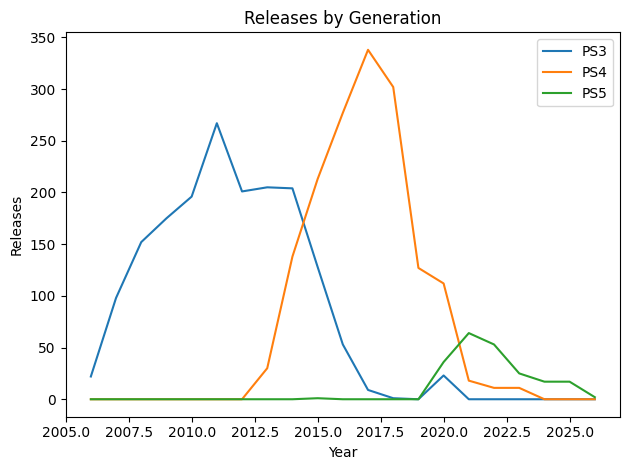

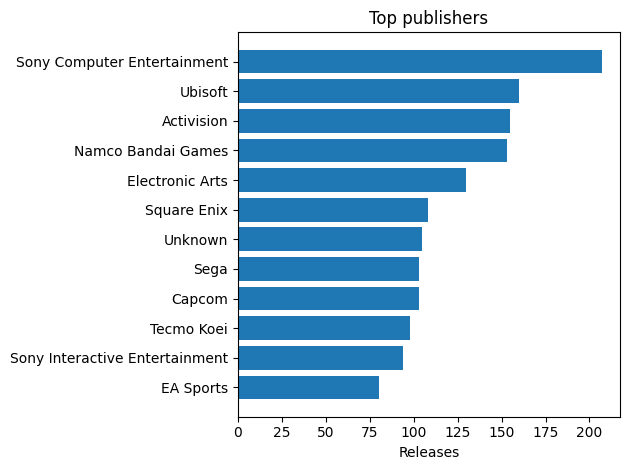

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('PlayStationSales.csv')
df.columns = df.columns.str.strip()

yc = [c for c in df.columns if c.lower()=='year']
dc = [c for c in df.columns if 'release' in c.lower() or 'date' in c.lower()]
if yc:
    df['Year'] = pd.to_numeric(df[yc[0]], errors='coerce')
elif dc:
    df['Year'] = pd.to_datetime(df[dc[0]], errors='coerce').dt.year
else:
    raise SystemExit('no year/date column')

pc = [c for c in df.columns if 'platform' in c.lower() or 'console' in c.lower() or 'system' in c.lower()]
df['Platform'] = df[pc[0]].astype(str) if pc else 'Unknown'
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)
df['Platform'] = df['Platform'].str.upper().str.replace(' ', '')

def gen(x):
    if 'PS5' in x: return 'PS5'
    if 'PS4' in x: return 'PS4'
    if 'PS3' in x: return 'PS3'
    return 'Other'
df['Generation'] = df['Platform'].map(gen)

pv = df.pivot_table(index='Year', columns='Generation', values='Platform', aggfunc='count').fillna(0).sort_index()
plt.figure()
for c in ['PS3','PS4','PS5','Other']:
    if c in pv.columns: plt.plot(pv.index, pv[c], label=c)
plt.xlabel('Year'); plt.ylabel('Releases'); plt.title('Releases by Generation'); plt.legend(); plt.tight_layout(); plt.show()

pubc = [c for c in df.columns if 'publisher' in c.lower() or 'company' in c.lower() or 'label' in c.lower()]
if pubc:
    top = df[pubc[0]].fillna('Unknown').value_counts().head(12).sort_values()
    plt.figure(); plt.barh(top.index, top.values); plt.xlabel('Releases'); plt.title('Top publishers'); plt.tight_layout(); plt.show()


# **Step 2 — Data Understanding**

## **What we do**
- Load PlayStationSales.csv and standardize column names.
- Extract Year from the Year or Release Date field.
- Normalize Platform text and map to Generation: PS3, PS4, PS5, Other.
- Build two quick views to understand the dataset shape.

## **Key views**
- Releases by Generation (line chart over years) - shows when PS3, PS4, PS5 had more or fewer launches.
- Top publishers (horizontal bar) - shows who releases the most titles in this dataset.

## **Notes**
- We avoid absolute unit sales here. Focus is on activity and composition.
- Missing values in Year/Publisher are cleaned (rows without year are dropped; missing publishers → "Unknown").
- These views guide Step 3 (Data Preparation) where we will create a normalized performance index inside platform × year and prepare series/franchise grouping.


/tmp/ipython-input-3150738852.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Year'] = pd.to_datetime(df[dc[0]], errors='coerce').dt.year


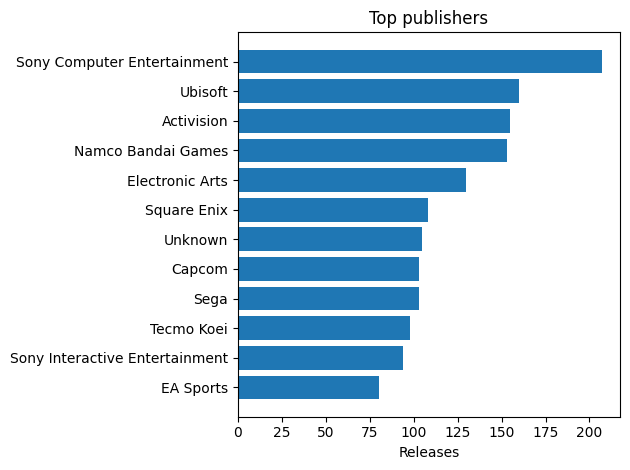

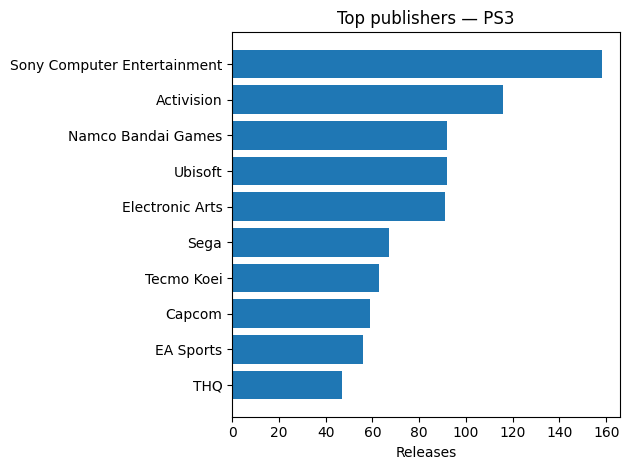

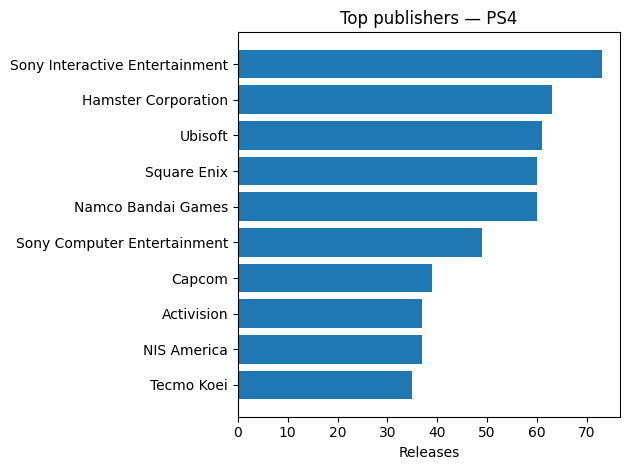

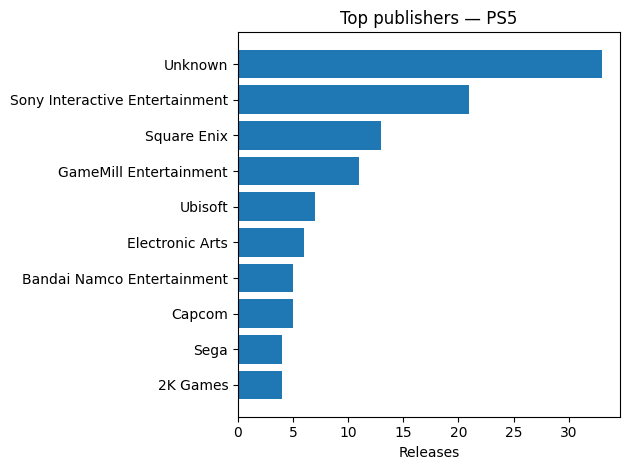

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('PlayStationSales.csv')
df.columns = df.columns.str.strip()

yc = [c for c in df.columns if c.lower()=='year']
dc = [c for c in df.columns if 'release' in c.lower() or 'date' in c.lower()]
if yc:
    df['Year'] = pd.to_numeric(df[yc[0]], errors='coerce')
elif dc:
    df['Year'] = pd.to_datetime(df[dc[0]], errors='coerce').dt.year
else:
    raise SystemExit('no year/date column')

pc = [c for c in df.columns if 'platform' in c.lower() or 'console' in c.lower() or 'system' in c.lower()]
df['Platform'] = df[pc[0]].astype(str) if pc else 'Unknown'
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)
df['Platform'] = df['Platform'].str.upper().str.replace(' ', '')

def gen(x):
    if 'PS5' in x: return 'PS5'
    if 'PS4' in x: return 'PS4'
    if 'PS3' in x: return 'PS3'
    return 'Other'
df['Generation'] = df['Platform'].map(gen)

pubc = [c for c in df.columns if 'publisher' in c.lower() or 'company' in c.lower() or 'label' in c.lower()]
pub_col = pubc[0] if pubc else None
if pub_col is None:
    raise SystemExit('no publisher column')

top = df[pub_col].fillna('Unknown').value_counts().head(12).sort_values()
plt.figure(); plt.barh(top.index, top.values); plt.xlabel('Releases'); plt.title('Top publishers'); plt.tight_layout(); plt.show()

for g in ['PS3','PS4','PS5']:
    sub = df[df['Generation']==g]
    if not sub.empty:
        topg = sub[pub_col].fillna('Unknown').value_counts().head(10).sort_values()
        plt.figure(); plt.barh(topg.index, topg.values); plt.xlabel('Releases'); plt.title(f'Top publishers — {g}'); plt.tight_layout(); plt.show()


In [7]:
import pandas as pd

df = pd.read_csv('PlayStationSales.csv')
mapping = pd.read_csv('publisher_mapping.csv')

df['Publisher'] = df['Publisher'].astype(str).str.strip()
mapping['publisher_original'] = mapping['publisher_original'].astype(str).str.strip()

map_dict = dict(zip(mapping['publisher_original'], mapping['publisher_clean']))

df['Publisher_clean'] = df['Publisher'].map(map_dict).fillna(df['Publisher'])

df.to_csv('PlayStationSales_with_clean_publishers.csv', index=False)
